In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv('stud_math.csv')

In [3]:
def apply_string_column(val, fix_str_nan=True):
    if val is None:
        return None
    
    if not isinstance(val, str):
        val = str(val)
        
    val = val.strip()
    if val == '':
        val = None
    elif fix_str_nan and val.lower() == 'nan':
        val = None
    
    return val


def fix_string_column(data, column):
    return data[column].apply(apply_string_column)

In [4]:
def ttest(data, columns, target_column):
    success = set()
    for column in columns:
        all_combs = list(combinations(df[column].value_counts().index[:10], 2))
        for comb in all_combs:
            ttest_res = ttest_ind(
                data[data[column] == comb[0]][target_column],
                data[data[column] == comb[1]][target_column],
            )
            if ttest_res.pvalue > 0.05/len(all_combs):
                success.add(column)
    return success

In [5]:
def drop_columns(data, columns):
    for_drop = set()
    for column in columns:
        if column in data.columns:
            for_drop.add(column)
    data.drop(columns=for_drop, inplace=True)

In [6]:
def describe_nominant_column(data, column, with_plots=True):
    uniq_count = data[column].nunique()
    null_count = len(data[pd.isnull(data[column])])
    print(f'Столбец {data[column].name}')
    print(f'Уникальные  : {uniq_count}/{len(data)} - {uniq_count / float(len(data)) * 100 :.2f}%')
    print(f'Незаполненные: {null_count}/{len(data)} - {null_count / float(len(data)) * 100 :.2f}%')
    print('Влияние на score:')
    ttest_pass = column in ttest(data, [column], data.score.name)
    if ttest_pass:
        print('Т-тест - есть влияние на score')
    else:
        print('Т-тест - нет влияния на score')
    display(df.groupby(column).score.describe())

    if with_plots:
        fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
        counts = data[column].value_counts()
        sns.barplot(x=counts.index, y=counts, ax=axs[0])
        sns.boxplot(x=column, y='score', data=data, ax=axs[1])

In [7]:
def fix_nominant_column(data, column, values):
    replace = data[column].value_counts().index[0]
    df.loc[~df[column].isin(values), column] = replace

In [8]:
def fill_by_counts(data, column):
    counts = data[column].value_counts()
    values = list(counts.index)
    size = len(data[~pd.isnull(data[column])])
    p = np.array([counts[x] / float(size) for x in values])
    data[column] = data[column].apply(lambda _: np.random.choice(values, size=1, p=p)[0])
    return data

In [9]:
def describe_corr(value):
    sign = 'положительная' if value >= 0 else 'отрицательная'
    abs_value = abs(value)
    effect = ''
    if abs_value < .1:
        effect = 'очень слабая'
    elif abs_value < .3:
        effect = 'слабая'
    elif abs_value < .5:
        effect = 'средняя'
    elif abs_value < .9:
        effect = 'высокая'
    else:
        effect = 'очень высокая'
    return f'{value :.2f} - {effect} {sign}'

In [10]:
def std_filter(seria):
    mean = seria.mean()
    triple_std = seria.std() * 3
    return seria.between(mean - triple_std, mean + triple_std)

In [11]:
def describe_column(data, column, with_plots=True, with_kde=True):
    uniq_count = data[column].nunique()
    null_count = len(data[pd.isnull(data[column])])
    filtered = data[std_filter(data[column])]
    print(f'Столбец {data[column].name}')
    print(f'Уникальные  : {uniq_count}/{len(data)} - {uniq_count / float(len(data)) * 100 :.2f}%')
    print(f'Незаполненные: {null_count}/{len(data)} - {null_count / float(len(data)) * 100 :.2f}%')
    print(f'Без выбросов: {len(filtered)}/{len(data)} - {len(filtered) / float(len(data)) * 100 :.2f}%')
    
    corr_value = data[['score', column]].corr()['score'][column]
    corr_value_filtered = filtered[['score', column]].corr()['score'][column]
    print(f'Корреляция в исходных данных: {describe_corr(corr_value)}')
    print(f'Корреляция в очищенных данных: {describe_corr(corr_value_filtered)}')
    
    if not with_plots:
        return
    
    plt.figure()
    if uniq_count < 20:
        bins=uniq_count
    else:
        bins = 20
        
    fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
    sns.distplot(
        df[column], 
        bins=bins, 
        kde=with_kde,
        ax=axs[0],
        axlabel=f'{column} все данные',
    )
    sns.distplot(
        filtered[column],
        bins=bins,
        kde=with_kde,
        ax=axs[1],
        axlabel=f'{column} без выбросов',
    )

# Разберемся с данными, первичная обработка

In [12]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

Переведем все столбцы в lowercase

In [13]:
df.columns = [column.lower() for column in df.columns]

# score — баллы по госэкзамену по математике

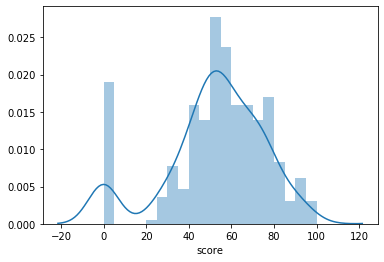

In [14]:
sns.distplot(df.score, bins=20, kde=True)

In [15]:
df.score.value_counts()[0]

37

Видно что есть выброс, у большого числа участников 0 баллов, удалим эти данные из выборки.

In [16]:
df = df[df.score > 0]

## school — аббревиатура школы, в которой учится ученик

Столбец school
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
school,,,,,,,,
GP,311.0,58.215434,16.282245,20.0,47.5,55.0,70.0,100.0
MS,41.0,54.268293,15.311800,25.0,45.0,50.0,65.0,95.0


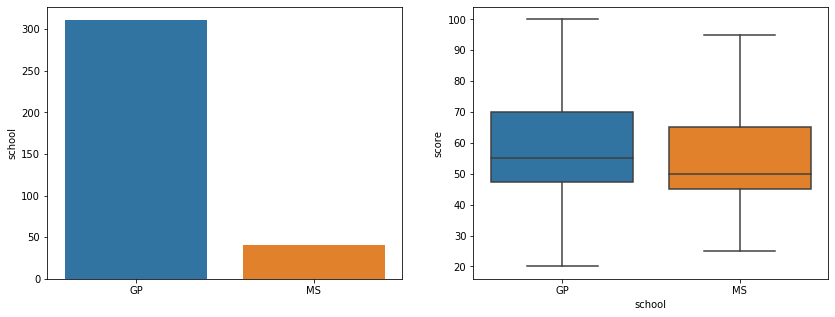

In [17]:
df.school = fix_string_column(df, 'school')
describe_nominant_column(df, 'school')

## sex — пол ученика ('F' - женский, 'M' - мужской)

Столбец sex
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,182.0,56.153846,15.969185,20.0,45.0,55.0,68.75,95.0
M,170.0,59.470588,16.318275,25.0,50.0,60.0,70.00,100.0


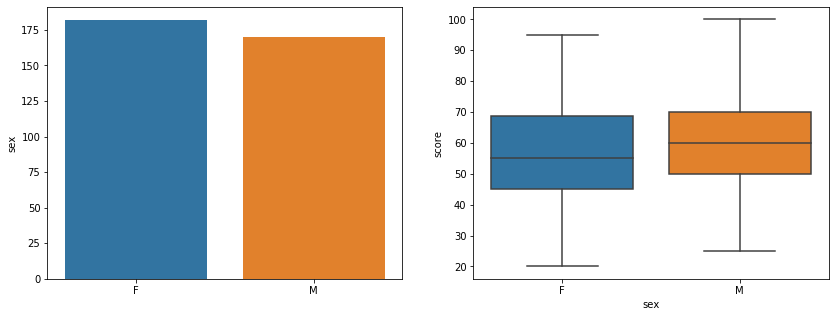

In [18]:
df.sex = fix_string_column(df, 'sex')
describe_nominant_column(df, 'sex')

Данные заполнены на 100%, оставляем столбец он влияет на score

## age — возраст ученика (от 15 до 22)

Столбец age
Уникальные  : 8/352 - 2.27%
Незаполненные: 0/352 - 0.00%
Без выбросов: 350/352 - 99.43%
Корреляция в исходных данных: -0.13 - слабая отрицательная
Корреляция в очищенных данных: -0.11 - слабая отрицательная


<Figure size 432x288 with 0 Axes>

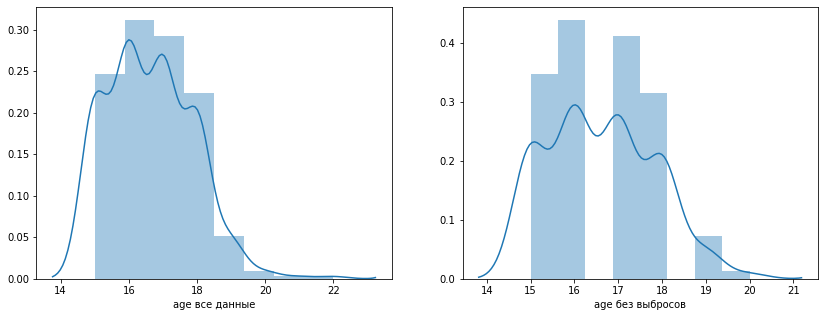

In [19]:
describe_column(df, 'age')

Пропусков нет, данные корректные, очень мало данных по ученикам старше 19, корреляция слабая, но есть

## address — тип адреса ученика ('U' - городской, 'R' - за городом)

Столбец address
Уникальные  : 2/352 - 0.57%
Незаполненные: 14/352 - 3.98%
Влияние на score:
Т-тест - нет влияния на score


,count,mean,std,min,25%,50%,75%,max
address,,,,,,,,
R,73.0,53.356164,16.203026,25.0,40.0,50.0,65.0,95.0
U,265.0,58.830189,16.182828,20.0,45.0,55.0,70.0,100.0


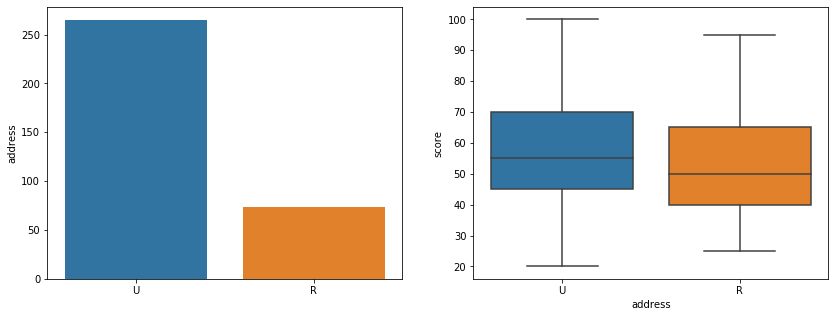

In [20]:
fix_string_column(df, 'address')
desc = describe_nominant_column(df, 'address')

Не влияет на score, удалим

In [21]:
drop_columns(df, ['address'])

## famsize — размер семьи('LE3' <= 3, 'GT3' >3)

Столбец famsize
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
famsize,,,,,,,,
GT3,241.0,58.070539,15.972346,20.0,50.0,55.0,70.0,95.0
LE3,111.0,57.072072,16.739562,25.0,45.0,55.0,70.0,100.0


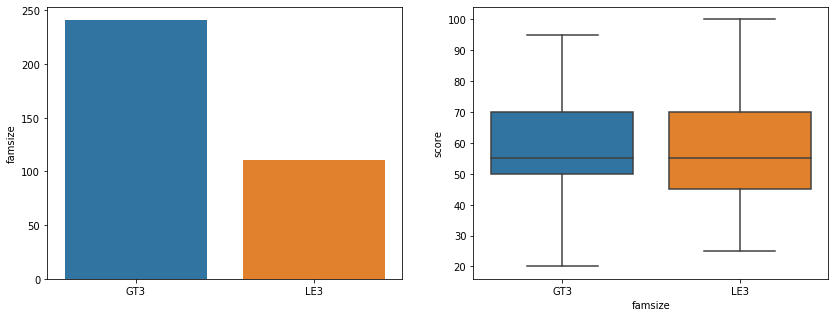

In [22]:
df.famsize = fix_string_column(df, 'famsize')
df = fill_by_counts(df, 'famsize')
describe_nominant_column(df, 'famsize')

Есть незаполненные значения, оставляем в датафрейме потому что Т-тест показывает влияние на score. Пропуски заполним сохраняя пропорцию в исходных данных.

# Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

Столбец pstatus
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
pstatus,,,,,,,,
A,39.0,58.717949,17.385639,25.0,50.0,60.0,72.5,90.0
T,313.0,57.635783,16.072799,20.0,45.0,55.0,70.0,100.0


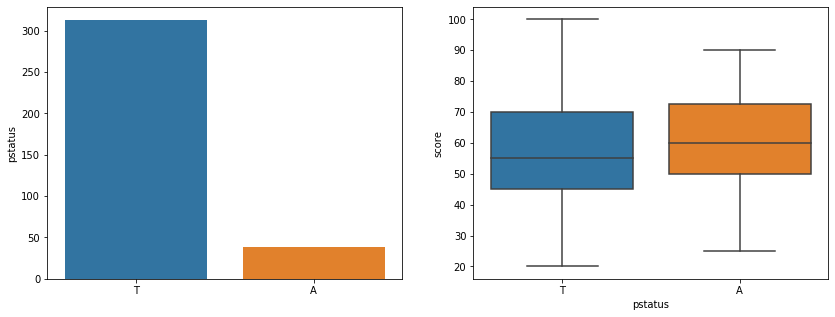

In [23]:
df.pstatus = fix_string_column(df, 'pstatus')
df = fill_by_counts(df, 'pstatus')
describe_nominant_column(df, 'pstatus')

Есть влияние на scroe, оставим эти данные в модели, пропуски заполним сохраняя пропорции

#  Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Столбец medu
Уникальные  : 5/352 - 1.42%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
medu,,,,,,,,
0.0,3.0,65.000000,17.320508,45.0,60.00,75.0,75.0,75.0
1.0,47.0,51.382979,12.756163,25.0,45.00,50.0,60.0,80.0
2.0,88.0,56.363636,13.744953,30.0,48.75,55.0,65.0,95.0
3.0,87.0,57.183908,17.112846,25.0,45.00,55.0,70.0,95.0
4.0,127.0,61.299213,17.493906,20.0,50.00,60.0,75.0,100.0


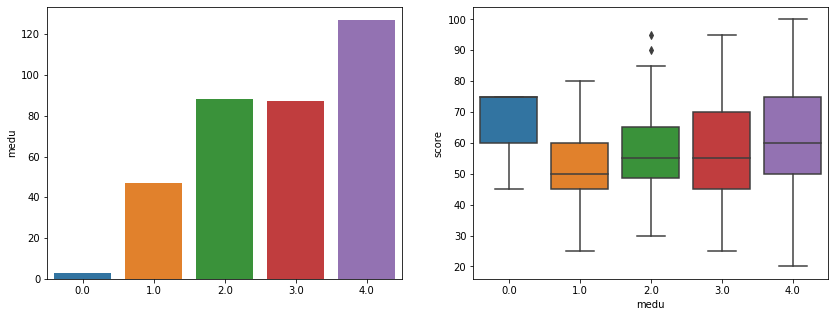

In [24]:
fix_nominant_column(df, 'medu', [0, 1, 2, 3, 4])
describe_nominant_column(df, 'medu')

# Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Столбец fedu
Уникальные  : 5/352 - 1.42%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
fedu,,,,,,,,
0.0,2.0,65.000000,21.213203,50.0,57.5,65.0,72.5,80.0
1.0,65.0,53.461538,15.075930,25.0,45.0,50.0,65.0,90.0
2.0,116.0,58.146552,16.239112,25.0,45.0,55.0,70.0,95.0
3.0,89.0,57.078652,16.511170,20.0,45.0,55.0,70.0,100.0
4.0,80.0,61.250000,16.098982,25.0,50.0,60.0,70.0,95.0


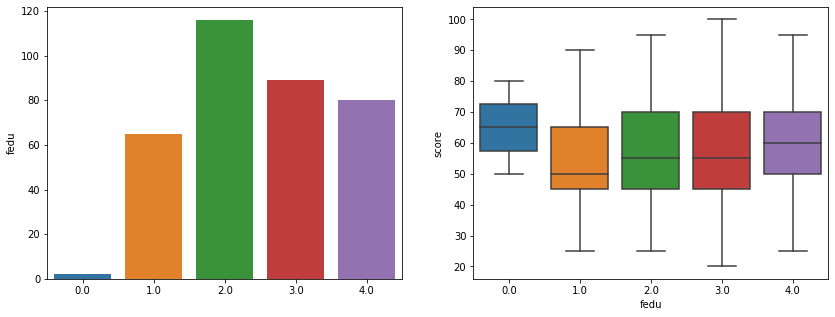

In [25]:
fix_nominant_column(df, 'fedu', [0, 1, 2, 3, 4])
describe_nominant_column(df, 'fedu')

Оставляем в модели

# Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

Столбец mjob
Уникальные  : 5/352 - 1.42%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
mjob,,,,,,,,
at_home,37.0,54.054054,14.232096,25.0,45.0,55.0,65.00,80.0
health,34.0,60.735294,16.008159,35.0,50.0,60.0,73.75,95.0
other,122.0,57.090164,17.017737,20.0,45.0,55.0,68.75,95.0
services,109.0,58.119266,16.213120,25.0,50.0,55.0,75.00,100.0
teacher,50.0,59.300000,15.616906,25.0,50.0,60.0,70.00,90.0


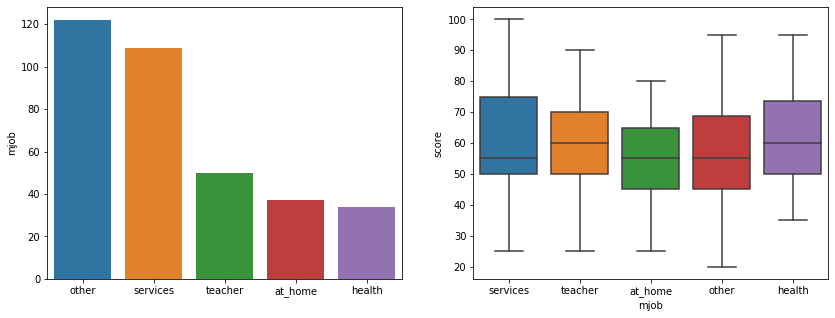

In [26]:
df.mjob = fix_string_column(df, 'mjob')
df = fill_by_counts(df, 'mjob')
describe_nominant_column(df, 'mjob')

# работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

Столбец fjob
Уникальные  : 5/352 - 1.42%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
fjob,,,,,,,,
at_home,14.0,56.428571,14.990840,30.0,51.25,55.0,60.0,90.0
health,11.0,56.363636,12.060454,45.0,47.50,50.0,65.0,80.0
other,198.0,56.969697,15.840547,25.0,45.00,55.0,70.0,95.0
services,101.0,58.267327,17.312360,20.0,45.00,55.0,70.0,100.0
teacher,28.0,62.678571,16.637872,30.0,50.00,65.0,75.0,90.0


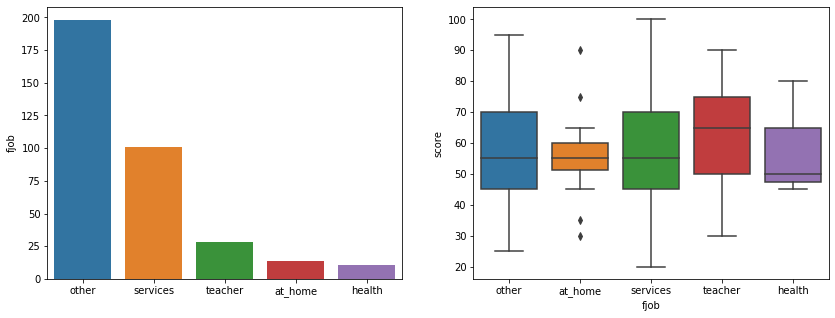

In [27]:
df.fjob = fix_string_column(df, 'fjob')
df = fill_by_counts(df, 'fjob')
describe_nominant_column(df, 'fjob')

# reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

Столбец reason
Уникальные  : 4/352 - 1.14%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
reason,,,,,,,,
course,126.0,58.015873,16.590110,25.0,46.25,55.0,70.0,100.0
home,100.0,56.200000,16.516291,25.0,45.00,55.0,65.0,95.0
other,35.0,59.285714,16.765812,25.0,50.00,60.0,72.5,85.0
reputation,91.0,58.516484,15.193100,20.0,50.00,55.0,70.0,95.0


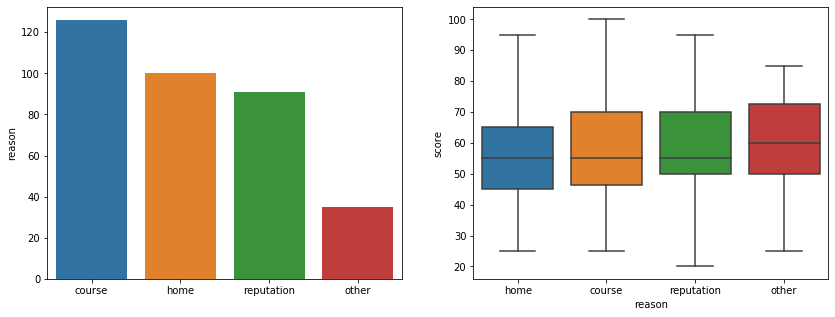

In [28]:
df.reason = fix_string_column(df, 'reason')
df = fill_by_counts(df, 'reason')
describe_nominant_column(df, 'reason')

# guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

Столбец guardian
Уникальные  : 3/352 - 0.85%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
guardian,,,,,,,,
father,92.0,61.141304,17.066503,25.0,50.0,62.5,75.0,100.0
mother,231.0,56.926407,15.909766,20.0,45.0,55.0,65.0,95.0
other,29.0,53.620690,14.261371,25.0,45.0,55.0,65.0,75.0


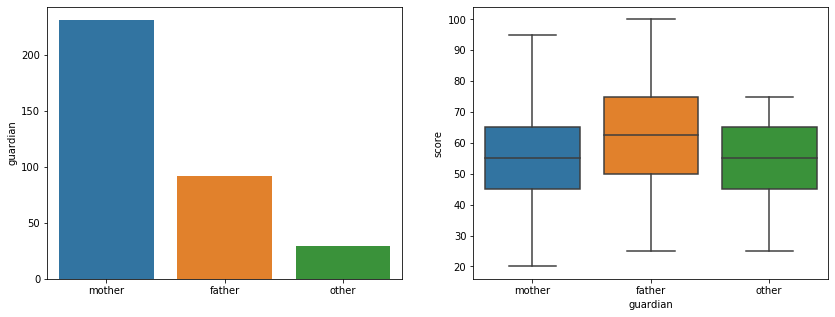

In [29]:
df.guardian = fix_string_column(df, 'guardian')
df = fill_by_counts(df, 'guardian')
describe_nominant_column(df, 'guardian')

Оставляем в модели

#  traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Столбец traveltime
Уникальные  : 4/352 - 1.14%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
traveltime,,,,,,,,
1.0,242.0,58.429752,16.797958,20.0,45.0,55.0,70.0,100.0
2.0,86.0,56.569767,15.151424,30.0,45.0,55.0,65.0,95.0
3.0,17.0,57.352941,14.696688,30.0,50.0,55.0,65.0,90.0
4.0,7.0,50.000000,9.128709,35.0,47.5,50.0,52.5,65.0


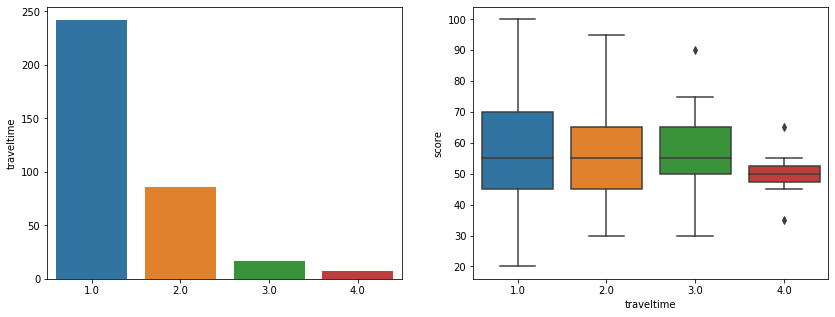

In [30]:
fix_nominant_column(df, 'traveltime', [1, 2, 3, 4])
describe_nominant_column(df, 'traveltime')

Оставляем в модели

# studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

Столбец studytime
Уникальные  : 4/352 - 1.14%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
studytime,,,,,,,,
1.0,90.0,56.611111,16.503792,25.0,45.0,55.0,68.75,95.0
2.0,180.0,55.972222,15.785727,20.0,45.0,55.0,65.00,95.0
3.0,58.0,62.758621,15.077938,35.0,50.0,60.0,75.00,95.0
4.0,24.0,63.333333,17.977442,30.0,50.0,62.5,75.00,100.0


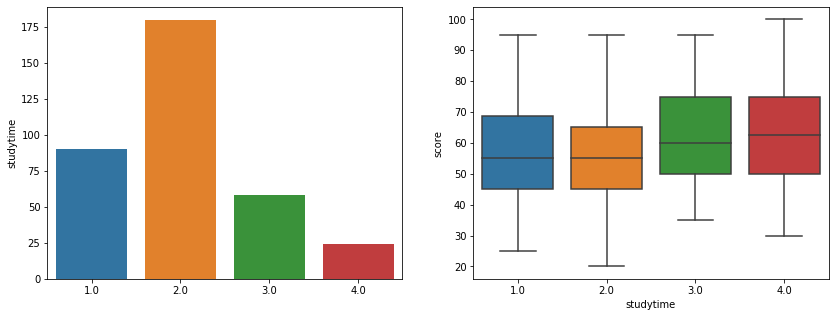

In [31]:
fix_nominant_column(df, 'studytime', [1, 2, 3, 4])
describe_nominant_column(df, 'studytime')

# failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

Столбец failures
Уникальные  : 4/352 - 1.14%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
failures,,,,,,,,
0.0,293.0,59.761092,15.976575,25.0,50.0,60.0,70.0,100.0
1.0,38.0,50.526316,13.294455,25.0,40.0,50.0,60.0,90.0
2.0,11.0,44.090909,15.782614,20.0,37.5,45.0,47.5,75.0
3.0,10.0,41.500000,8.834906,25.0,35.0,42.5,50.0,50.0


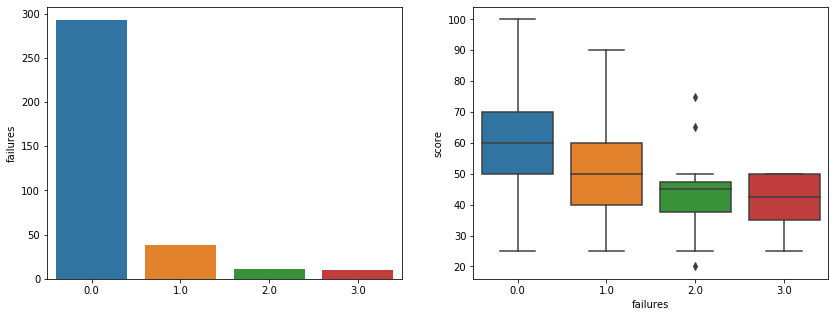

In [32]:
fix_nominant_column(df, 'failures', [0, 1, 2, 3])
describe_nominant_column(df, 'failures')

# schoolsup — дополнительная образовательная поддержка (yes или no)

Столбец schoolsup
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - нет влияния на score


,count,mean,std,min,25%,50%,75%,max
schoolsup,,,,,,,,
no,304.0,59.292763,16.134024,20.0,50.0,60.0,70.0,100.0
yes,48.0,48.020833,13.035940,25.0,40.0,50.0,55.0,85.0


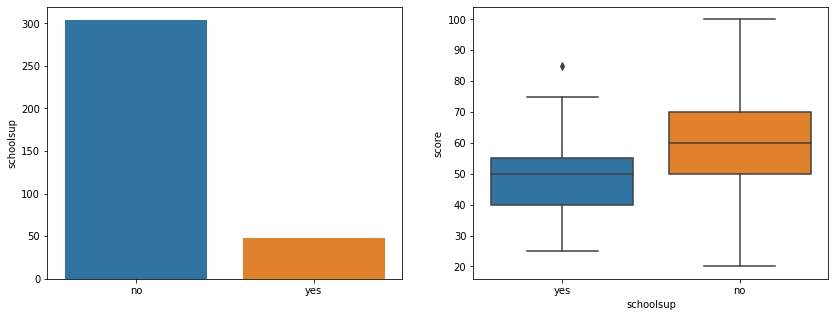

In [33]:
fix_nominant_column(df, 'schoolsup', ['yes', 'no'])
describe_nominant_column(df, 'schoolsup')

На boxplot видим что score сильно отличается в зависимости от schoolsup, но Т-тест говорит о том что значимого влияния нет

In [34]:
drop_columns(df, ['schoolsup'])

# famsup — семейная образовательная поддержка (yes или no)

Столбец famsup
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
famsup,,,,,,,,
no,120.0,58.583333,16.246310,20.0,50.0,55.0,70.0,100.0
yes,232.0,57.327586,16.195919,25.0,45.0,55.0,70.0,95.0


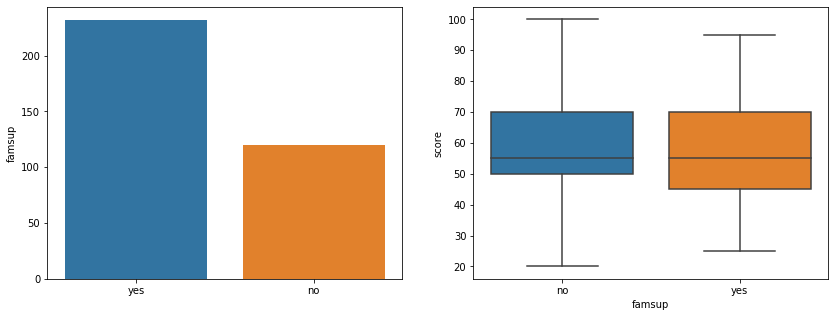

In [35]:
fix_nominant_column(df, 'famsup', ['yes', 'no'])
describe_nominant_column(df, 'famsup')

# paid — дополнительные платные занятия по математике (yes или no)

Столбец paid
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
paid,,,,,,,,
no,206.0,57.839806,16.764322,25.0,45.00,55.0,70.0,100.0
yes,146.0,57.636986,15.427195,20.0,46.25,55.0,70.0,95.0


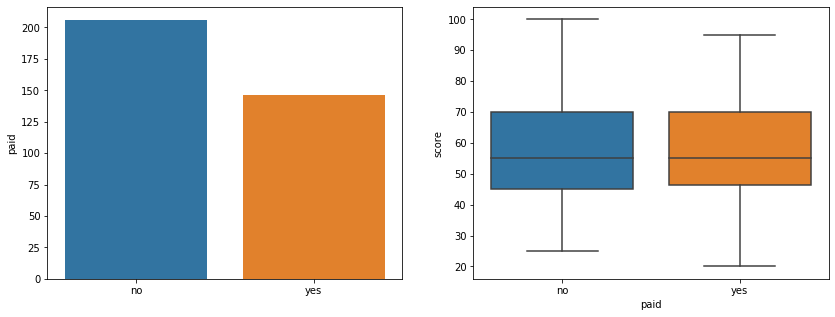

In [36]:
fix_nominant_column(df, 'paid', ['yes', 'no'])
describe_nominant_column(df, 'paid')

# activities — дополнительные внеучебные занятия (yes или no)

Столбец activities
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
activities,,,,,,,,
no,168.0,56.845238,16.682663,20.0,45.0,55.0,70.0,95.0
yes,184.0,58.586957,15.747774,25.0,50.0,55.0,70.0,100.0


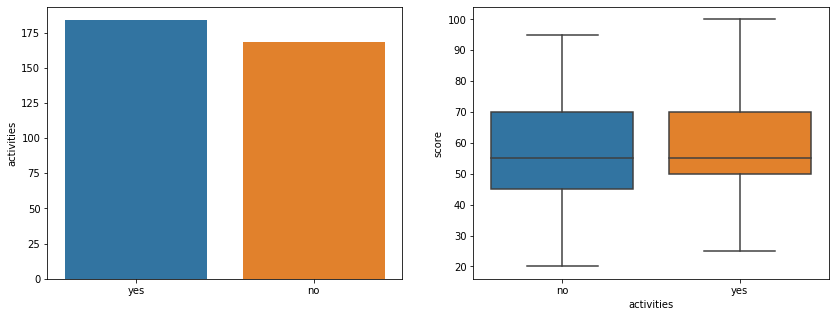

In [37]:
fix_nominant_column(df, 'activities', ['yes', 'no'])
describe_nominant_column(df, 'activities')

# nursery — посещал детский сад (yes или no)

Столбец nursery
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
nursery,,,,,,,,
no,68.0,56.617647,13.914482,25.0,50.0,55.0,66.25,90.0
yes,284.0,58.028169,16.712681,20.0,45.0,55.0,70.00,100.0


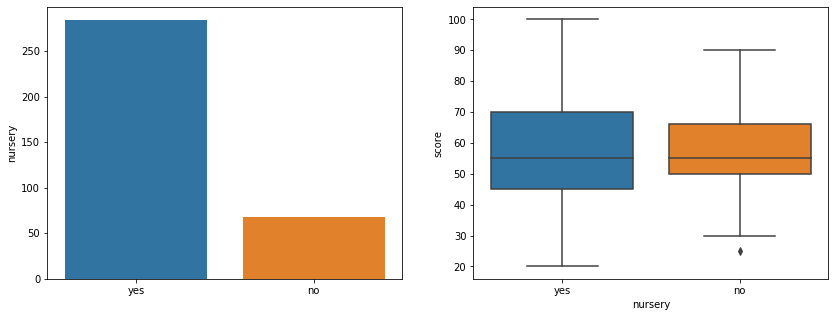

In [38]:
fix_nominant_column(df, 'nursery', ['yes', 'no'])
describe_nominant_column(df, 'nursery')

#  higher — хочет получить высшее образование (yes или no)

Столбец higher
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
higher,,,,,,,,
no,13.0,49.230769,9.540736,35.0,40.0,50.0,60.0,65.0
yes,339.0,58.082596,16.322715,20.0,50.0,55.0,70.0,100.0


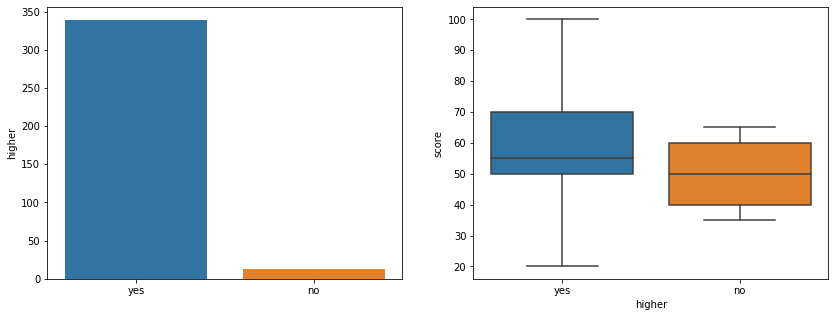

In [39]:
fix_nominant_column(df, 'higher', ['yes', 'no'])
describe_nominant_column(df, 'higher')

# internet — наличие интернета дома (yes или no)

Столбец internet
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
internet,,,,,,,,
no,49.0,55.102041,14.415335,30.0,45.0,55.0,65.0,90.0
yes,303.0,58.184818,16.452988,20.0,47.5,55.0,70.0,100.0


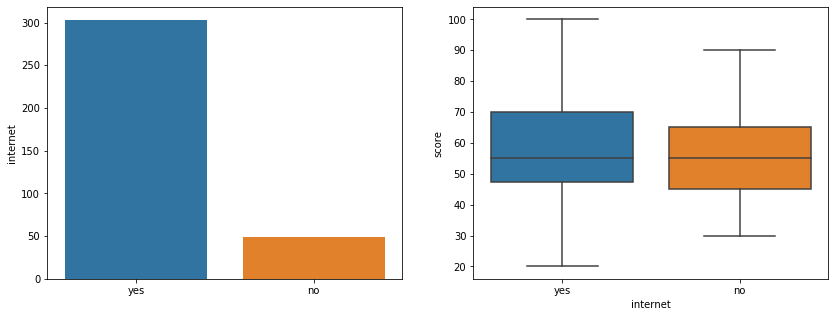

In [40]:
fix_nominant_column(df, 'internet', ['yes', 'no'])
describe_nominant_column(df, 'internet')

# romantic — в романтических отношениях (yes или no)

Столбец romantic
Уникальные  : 2/352 - 0.57%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
romantic,,,,,,,,
no,248.0,58.326613,16.753819,25.0,50.0,55.0,70.0,100.0
yes,104.0,56.394231,14.787438,20.0,45.0,55.0,65.0,90.0


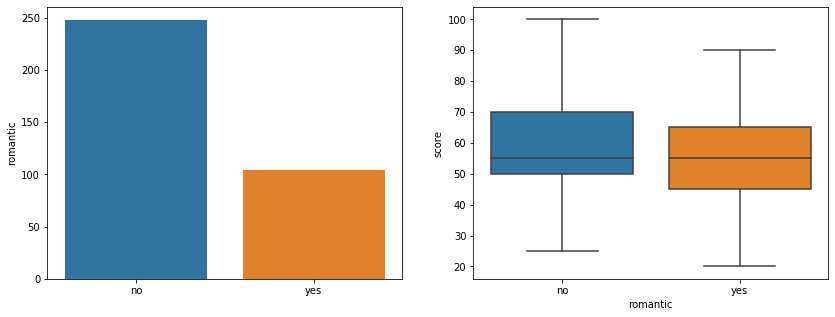

In [41]:
fix_nominant_column(df, 'romantic', ['yes', 'no'])
describe_nominant_column(df, 'romantic')

# famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

Столбец famrel
Уникальные  : 5/352 - 1.42%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
famrel,,,,,,,,
1.0,6.0,64.166667,8.612007,55.0,60.0,62.5,65.00,80.0
2.0,14.0,58.928571,18.099997,25.0,47.5,57.5,75.00,85.0
3.0,56.0,56.964286,15.888205,20.0,45.0,55.0,66.25,95.0
4.0,188.0,56.409574,15.929568,25.0,45.0,55.0,70.00,100.0
5.0,88.0,60.511364,16.901333,25.0,50.0,60.0,75.00,95.0


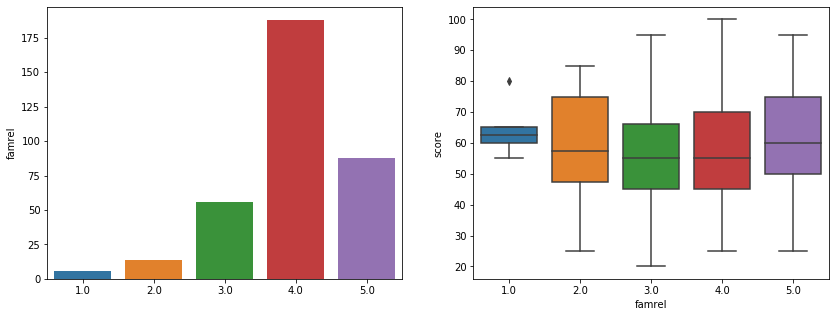

In [42]:
fix_nominant_column(df, 'famrel', [1, 2, 3, 4, 5])
describe_nominant_column(df, 'famrel')

# freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

Столбец freetime
Уникальные  : 5/352 - 1.42%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
freetime,,,,,,,,
1.0,16.0,54.375000,17.594980,30.0,43.75,50.0,57.5,90.0
2.0,59.0,61.440678,15.314261,30.0,50.00,60.0,70.0,100.0
3.0,140.0,56.857143,15.365369,25.0,48.75,55.0,70.0,95.0
4.0,102.0,56.764706,16.192638,20.0,45.00,55.0,70.0,95.0
5.0,35.0,59.571429,19.754799,25.0,50.00,60.0,72.5,95.0


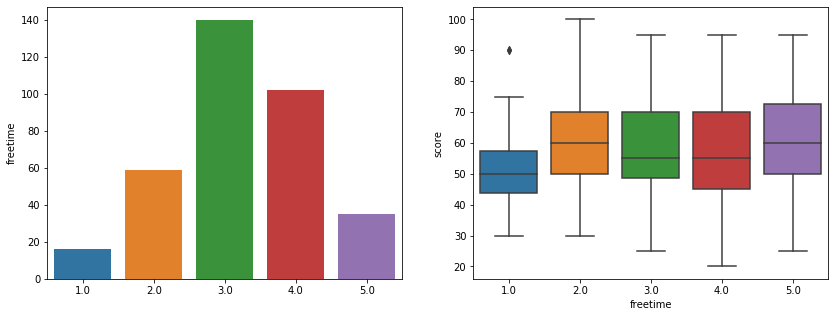

In [43]:
fix_nominant_column(df, 'freetime', [1, 2, 3, 4, 5])
describe_nominant_column(df, 'freetime')

# goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

Столбец goout
Уникальные  : 5/352 - 1.42%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
goout,,,,,,,,
1.0,19.0,59.736842,14.669856,30.0,50.0,55.0,70.0,85.0
2.0,92.0,61.467391,15.362614,30.0,50.0,60.0,75.0,100.0
3.0,124.0,58.548387,16.139310,25.0,50.0,55.0,70.0,95.0
4.0,74.0,54.189189,15.659629,25.0,40.0,52.5,65.0,95.0
5.0,43.0,52.790698,17.871976,20.0,40.0,50.0,62.5,90.0


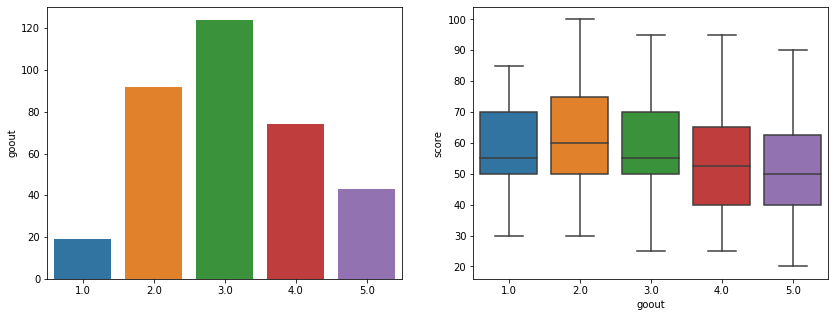

In [44]:
fix_nominant_column(df, 'goout', [1, 2, 3, 4, 5])
describe_nominant_column(df, 'goout')

#  health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

Столбец health
Уникальные  : 5/352 - 1.42%
Незаполненные: 0/352 - 0.00%
Влияние на score:
Т-тест - есть влияние на score


,count,mean,std,min,25%,50%,75%,max
health,,,,,,,,
1.0,45.0,62.000000,18.103239,20.0,50.0,65.0,75.0,95.0
2.0,36.0,61.388889,17.752711,30.0,50.0,62.5,70.0,100.0
3.0,81.0,55.000000,14.726676,25.0,45.0,55.0,60.0,95.0
4.0,53.0,57.547170,17.030026,25.0,45.0,55.0,70.0,95.0
5.0,137.0,57.116788,15.407726,25.0,45.0,55.0,70.0,90.0


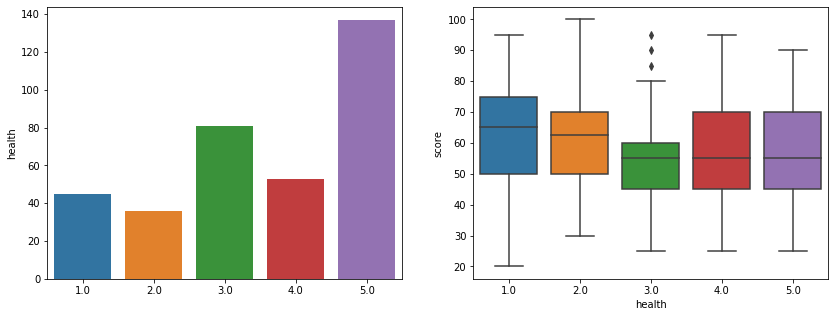

In [45]:
fix_nominant_column(df, 'health', [1, 2, 3, 4, 5])
describe_nominant_column(df, 'health')

# absences — количество пропущенных занятий

Столбец absences
Уникальные  : 36/352 - 10.23%
Незаполненные: 10/352 - 2.84%
Без выбросов: 340/352 - 96.59%
Корреляция в исходных данных: -0.01 - очень слабая отрицательная
Корреляция в очищенных данных: -0.21 - слабая отрицательная


<Figure size 432x288 with 0 Axes>

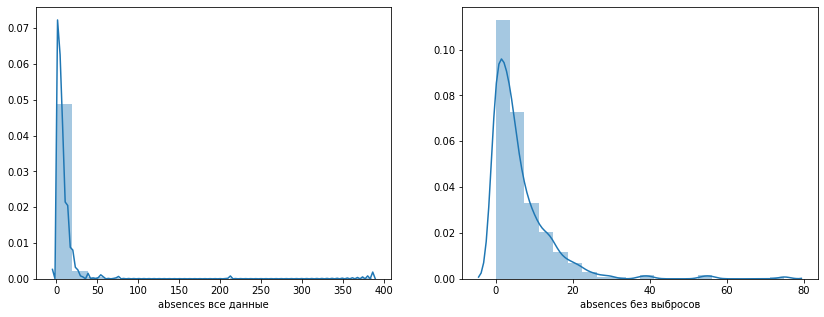

In [46]:
describe_column(df, 'absences')

Корреляция есть, выбросы заменим на значениt .95 квантиля, пропущенные значения на моду

Столбец absences
Уникальные  : 21/352 - 5.97%
Незаполненные: 0/352 - 0.00%
Без выбросов: 352/352 - 100.00%
Корреляция в исходных данных: -0.24 - слабая отрицательная
Корреляция в очищенных данных: -0.24 - слабая отрицательная


<Figure size 432x288 with 0 Axes>

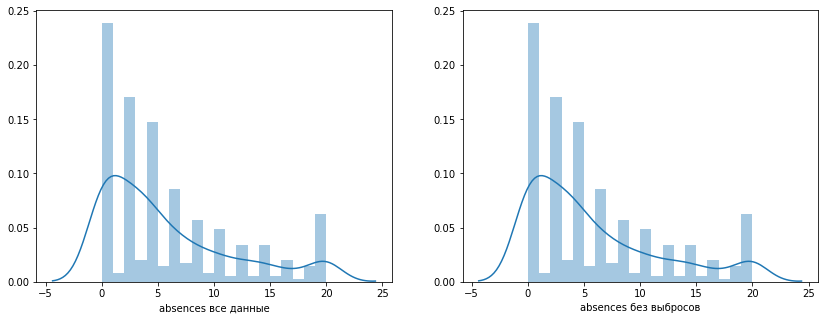

In [47]:
q95 = df.absences.quantile(.95)
df.loc[df.absences > q95, 'absences'] = q95
df.loc[pd.isnull(df.absences), 'absences'] = float(df.absences.mode())
describe_column(df, 'absences')

# Результаты
Большая часть данных заполнена корректна, удалено из набора данных всего два столбца - address и schoolsup, все оставльные остаются в модели